# zerion_api

> Endpoints for the `zerion` api.

In [ ]:
#|default_exp zerion_api

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export

import json
import requests
import os
from dotenv import load_dotenv
load_dotenv()

ZERION_AUTH = os.environ.get('zerion_auth')

In [ ]:
#| hide

_address = '0x7364a0f792e073814B426c918bf72792575b6c18'

In [ ]:
#| export

def get_portfolio_value(address:str):
    """Get the total value of a portfolio in USD"""
    #TODO: Obviously need to complete docstring etc, but we can leave as vague for now; unclear if we will
    #e.g. wrap in class etc.

    #API docs: https://developers.zerion.io/reference/getwalletportfolio

    #COMMENT: note that the docs have some nice info about different responses, e.g. 202 etc. This may be useful later on.

    url = f"https://api.zerion.io/v1/wallets/{address}/portfolio?currency=usd"

    headers = {
        "accept": "application/json",
        "authorization": ZERION_AUTH
    }

    response = requests.get(url, headers=headers)

    return response.json()

if __name__ == '__main__':
    _dict = get_portfolio_value(_address)
    print(f"Portfolio value according to zerion is: {_dict['data']['attributes']['positions_distribution_by_type']['wallet']}")


Portfolio value according to zerion is: 1149.1539322754966


Kinda complicated to key-index in, but we can use for debugging etc. Anyway...

In [ ]:
_address

'0x7364a0f792e073814B426c918bf72792575b6c18'

Next, get list of wallets positions:

In [ ]:
#| export

def get_wallet_positions(address:str, 
                         position_types:list[str]=None,
                         protocol_ids:list[str]=None,
                         fungible_ids:list[str]=None,
                         currency:str='usd'):
    """This endpoint returns a list of wallet positions.
    
        API docs: https://developers.zerion.io/reference/listwalletpositions
    """ 

    position_types_str = ''
    protocol_ids_str = ''
    fungible_ids_str = ''
    
    if position_types:
        position_types_str = f"filter[position_types]={','.join(position_types)}&"
    if protocol_ids:
        protocol_ids_str = f"filter[protocol_ids]={','.join(protocol_ids)}&"
    if fungible_ids:
        fungible_ids_str = f"filter[fungible_ids]={','.join(fungible_ids)}&"

    url = f"https://api.zerion.io/v1/wallets/{address}/positions/?currency={currency}&{position_types_str}{protocol_ids_str}{fungible_ids_str}filter[trash]=only_non_trash&sort=value"

  

    headers = {
        "accept": "application/json",
        "authorization": ZERION_AUTH
              }

    response = requests.get(url, headers=headers)


    return response.json() 

#This is mostly to help prototyping below, perhaps we will put its own cell explaining "how to use" eventually
if __name__ == '__main__':

    _dict = get_wallet_positions(_address)
    _portfolio = [_dict['data'][i]['attributes'] for i in range(len(_dict['data']))]
    print(f"First item in portfolio is: {_portfolio[0]}")
    print('Note that there is other information in the _dict object:\n')
    for k,v in _dict['data'][0].items():
        print(f"\tKey type is: {type(k)}, Value type is: {type(v)}")
        print(f"\tKey: {k}, Value: {v}\n")



First item in portfolio is: {'parent': None, 'protocol': None, 'name': 'Asset', 'position_type': 'wallet', 'quantity': {'int': '10642258892672793599819', 'decimals': 18, 'float': 10642.258892672793, 'numeric': '10642.258892672793599819'}, 'value': 900.09260780899, 'price': 0.084577214, 'changes': {'absolute_1d': 89.42581596472257, 'percent_1d': 11.031143358084128}, 'fungible_info': {'name': 'Revest', 'symbol': 'RVST', 'icon': {'url': 'https://token-icons.s3.amazonaws.com/0x120a3879da835a5af037bb2d1456bebd6b54d4ba.png'}, 'flags': {'verified': False}, 'implementations': [{'chain_id': 'ethereum', 'address': '0x120a3879da835a5af037bb2d1456bebd6b54d4ba', 'decimals': 18}]}, 'flags': {'displayable': True, 'is_trash': False}, 'updated_at': '2023-09-10T02:19:59Z', 'updated_at_block': 18102938}
Note that there is other information in the _dict object:

	Key type is: <class 'str'>, Value type is: <class 'str'>
	Key: type, Value: positions

	Key type is: <class 'str'>, Value type is: <class 'str'>

Alright, let's work out how to extract the data that we need:

In [ ]:
print(f"The name of first guy in portfolio is: {_portfolio[0]['fungible_info']['name']}")
print(f"The symbol of first guy in portfolio is: {_portfolio[0]['fungible_info']['symbol']}")
print(f"The value of first guy in portfolio is: {_portfolio[0]['value']}")

The name of first guy in portfolio is: Revest
The symbol of first guy in portfolio is: RVST
The value of first guy in portfolio is: 900.09260780899


In [ ]:
#Simple test: summing portfolio value should get same result as earlier call

none_to_zero = lambda x: 0 if x is None else x

sum([none_to_zero(asset['value']) for asset in _portfolio])

#Ok, it is fairly close, but not exactly the same. A bit annoying but ok. 
#1122.864752311196

1149.1118605095696

Get "chart" for fungible asset

In [ ]:
#| export

def get_chart(address:str,period:str='max',currency:str='usd'):
    """The 'charts' endpoint in the Zerion API allows users to retrieve a chart for a specific fungible asset.
        `period` may be any of: 'max','hour', 'day', 'week', 'month', 'year'.
    
    """

    url = f"https://api.zerion.io/v1/fungibles/{address}/charts/{period}?currency={currency}"

    headers = {
        "accept": "application/json",
        "authorization": ZERION_AUTH
              }


    response = requests.get(url, headers=headers)
    return response.json()



How to use `get_chart`:

In [ ]:
_tokenaddress = '0x72e4f9f808c49a2a61de9c5896298920dc4eeea9' #hpbitcoin
_dict = get_chart(_tokenaddress)

In [ ]:
_dict['data']['attributes'].keys()

dict_keys(['begin_at', 'end_at', 'stats', 'points'])

We can get the `points` like this:

In [ ]:
_points = _dict['data']['attributes']['points']
_points[0]

[1683763114, 0.00010612811086547703]

In [ ]:
#from api_endpoints.etherscan_api import *
#blockfetcher = BlockFetcher(etherscan_api_key=etherscan_api_key)
#blockfetcher.get_block_for_date(_dict['data']['attributes']['begin_at'].split('T')[0])

We now have historical prices and can extract:

In [ ]:
#| export

import datetime
from collections import defaultdict

def unix_timestamp_to_date(unix_timestamp):
    return datetime.datetime.utcfromtimestamp(unix_timestamp).strftime('%Y/%m/%d')

def timestamp_price_pairs_to_date_dict(points:list)->dict:
    """Inputs:
            points: list of lists (pairs) where first coord is unix timestamp, second is price on that date.
                    e.g. [1683788578, 0.00010605266543295529] 
       Outputs:
                    dict where key is date string and value is price on that date.
       Comment:
                    The source code is basically self explanatory.      
    """

    return {unix_timestamp_to_date(point[0]): point[1] for point in points}

def timestamp_price_pairs_to_date(points:list)->list:
    """Inputs:
            points: list of lists (pairs) where first coord is unix timestamp, second is price on that date.
                    e.g. [1683788578, 0.00010605266543295529] 
       Outputs:
                    list of lists (pairs) where first coord is date string, second is price on that date.
                    e.g. ['2023/05/11', 0.00010605266543295529] 
       Comment:
                    The source code is basically self explanatory.      
    """

    return [[unix_timestamp_to_date(point[0]), point[1]] for point in points]

def timestamp_price_pairs_to_avg_date_dict(points: list) -> dict:
    """Inputs:
            points: list of lists (pairs) where first coord is unix timestamp, second is price on that date.
                    e.g. [1683788578, 0.00010605266543295529] 
       Outputs:
                    dict where key is the date string and value is the average price for that date.
        
    """
    
    date_price_aggregator = defaultdict(lambda: {'sum': 0, 'count': 0})

    for point in points:
        date = unix_timestamp_to_date(point[0])
        date_price_aggregator[date]['sum'] += point[1]
        date_price_aggregator[date]['count'] += 1

    return {date: data['sum']/data['count'] for date, data in date_price_aggregator.items()}



How to use: 

In [ ]:
price_dict = timestamp_price_pairs_to_avg_date_dict(_points)
print(price_dict.keys())
print(price_dict.values())


dict_keys(['2023/05/10', '2023/05/11', '2023/05/12', '2023/05/13', '2023/05/14', '2023/05/15', '2023/05/16', '2023/05/17', '2023/05/18', '2023/05/19', '2023/05/20', '2023/05/21', '2023/05/22', '2023/05/23', '2023/05/24', '2023/05/25', '2023/05/26', '2023/05/27', '2023/05/28', '2023/05/29', '2023/05/30', '2023/05/31', '2023/06/01', '2023/06/02', '2023/06/03', '2023/06/04', '2023/06/05', '2023/06/06', '2023/06/07', '2023/06/08', '2023/06/09', '2023/06/10', '2023/06/11', '2023/06/12', '2023/06/13', '2023/06/14', '2023/06/15', '2023/06/16', '2023/06/17', '2023/06/18', '2023/06/19', '2023/06/20', '2023/06/21', '2023/06/22', '2023/06/23', '2023/06/24', '2023/06/25', '2023/06/26', '2023/06/27', '2023/06/28', '2023/06/29', '2023/06/30', '2023/07/01', '2023/07/02', '2023/07/03', '2023/07/04', '2023/07/05', '2023/07/06', '2023/07/07', '2023/07/08', '2023/07/09', '2023/07/10', '2023/07/11', '2023/07/12', '2023/07/13', '2023/07/14', '2023/07/15', '2023/07/16', '2023/07/17', '2023/07/18', '2023/07/

Plot as sanity check:

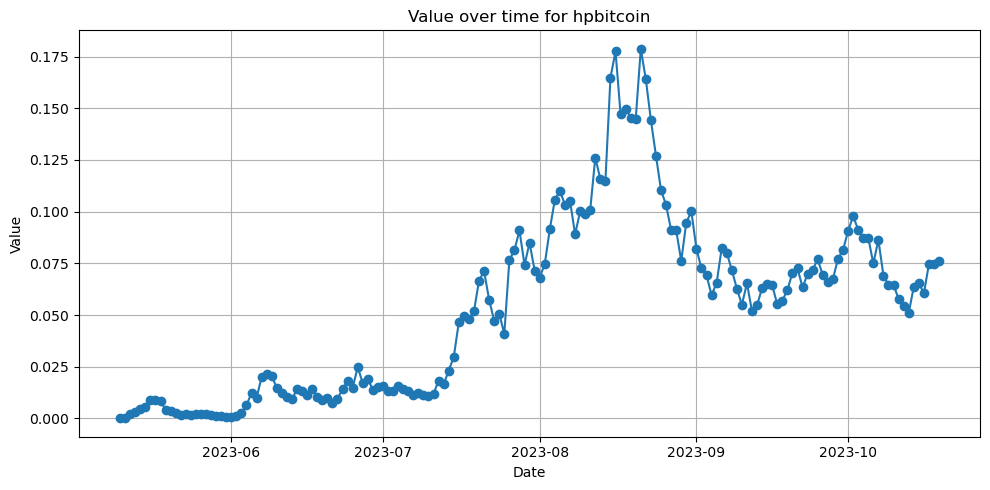

In [ ]:
# Extract keys (dates) and values
dates = sorted(price_dict.keys())
values = [price_dict[date] for date in dates]

# Convert string dates to datetime objects for plotting
parsed_dates = [datetime.datetime.strptime(date, "%Y/%m/%d") for date in dates]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(parsed_dates, values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Value over time for hpbitcoin')
plt.grid(True)
plt.tight_layout()
plt.show()
#This code will display a simple line plot with your dates on the x-axis and the corresponding values on the y-axis. Adjust the aesthetics as needed.



![Alt text](hpbitcoin_chart.png)

Test:

In [ ]:
#| hide

# Test
timestamp = 1683888999
assert (unix_timestamp_to_date(timestamp)) == '2023/05/12'

# Test
point_dict = timestamp_price_pairs_to_date_dict(_points)
assert point_dict['2023/05/11'] == 0.00010605266543295529

def test_timestamp_price_pairs_to_avg_date_dict():
    # Test data
    sample_points = [
        [1683788578, 0.00010605266543295529],
        [1683788578, 0.00020605266543295529],
        [1683874999, 0.002228218941912582],
        [1683874999, 0.003228218941912582],
        [1683874999, 0.004228218941912582],
        [1683961399, 0.0030039317914723218],
        [1683961399, 0.0040039317914723218]
    ]
    
    # Convert using function
    avg_date_price_dict = timestamp_price_pairs_to_avg_date_dict(sample_points)
    
    # Verify unique dates
    assert len(avg_date_price_dict) == 3, "Expected 3 unique dates in the dictionary"
    
    # Verify average calculations
    # For 2023/05/11
    assert avg_date_price_dict['2023/05/11'] == (0.00010605266543295529 + 0.00020605266543295529) / 2, "Incorrect average for 2023/05/11"
    # For 2023/05/12
    assert avg_date_price_dict['2023/05/12'] == (0.002228218941912582 + 0.003228218941912582 + 0.004228218941912582) / 3, "Incorrect average for 2023/05/12"
    # For 2023/05/13
    assert avg_date_price_dict['2023/05/13'] == (0.0030039317914723218 + 0.0040039317914723218) / 2, "Incorrect average for 2023/05/13"

    #print("All tests passed!")

# Test 
test_timestamp_price_pairs_to_avg_date_dict() #run several tests



def test_are_dates_one_day_apart(dates):
    parsed_dates = [datetime.datetime.strptime(date, "%Y/%m/%d") for date in dates]
    assert all(b - a == datetime.timedelta(days=1) for a, b in zip(parsed_dates, parsed_dates[1:]))

#Test
_dates = price_dict.keys()
test_are_dates_one_day_apart(_dates)


In [ ]:
#| hide

price_dict['2023/05/11']

0.00010605266543295529

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()